# Autoencoder Univariate Training (Expiriment 2)

 Vinayak Sharma
  
 This notebook aims to train an autoencoder on univariate timeseries data from EKS Performance metrics. The training data is 'non-anomalous'. 

 The model and implementation techniques can be found in the following github: https://github.com/emerelte/kad
 
 The research paper that this work is based on can be found here: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9925210

------

In [29]:
##global variable
timesteps = 12
time_steps = 12
batch_size = 6
n_samples = batch_size*100

## Imports

In [30]:
# !pip install -r /root/eks-ml-pipeline/modeling/kad/kad/requirements.txt
# # # !pip install keras
# # # !pip install tensorflow

In [31]:
# !pip install tensorflow

In [32]:
# import matplotlib as mpl
# mpl.rcParams.keys()

In [33]:
# !pip install --upgrade matplotlib

In [34]:
pwd

'/root/eks-ml-pipeline'

In [35]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import sys
import statsmodels.api as sm
import os
import keras
from keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from modeling.autoencoder_model_dish_5g import Autoencoder_Model_Dish_5g

from sklearn.model_selection import train_test_split



In [36]:
pd.set_option('display.max_rows', None)

First lets read in our training sample set 

In [37]:
training_df_full = pd.read_parquet('/root/eks-ml-pipeline/feature_engineering/healthy_train_data_eks_one_day')

In [38]:
training_df_full.head()

,Timestamp,InstanceId,ClusterName,node_cpu_utilization,node_cpu_limit,node_cpu_request,node_cpu_usage_total
0,1654632329974,i-02ff02960edb2ede8,nms-cluster-allot,0.177143,96000,22320,170.056888
1,1654632335207,i-08a448576feb6e96c,cc-ndc-eks-cluster-staging-cluster,0.317641,64000,2016,203.290496
2,1654635616109,i-093473861e74eaf2d,mt-ndc-eks-cluster-dev-mt-use1,0.947020,16000,1266,151.523174
3,1654632344540,i-01470d8d8e7b4fd2f,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,2.933662,4000,1266,117.346479
4,1654632340883,i-0b36e8825c482f762,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,1.876441,4000,1066,75.057632


In [13]:
columns_to_keep = ['Timestamp','InstanceId','node_cpu_utilization']

In [14]:
training_df = training_df_full.drop(training_df_full.columns.difference(columns_to_keep),1, inplace=False)
training_df['Timestamp'] = pd.to_datetime(training_df['Timestamp'], unit='ms')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [15]:
training_df.head()

,Timestamp,InstanceId,node_cpu_utilization
0,2022-06-07 20:05:29.974,i-02ff02960edb2ede8,0.177143
1,2022-06-07 20:05:35.207,i-08a448576feb6e96c,0.317641
2,2022-06-07 21:00:16.109,i-093473861e74eaf2d,0.947020
3,2022-06-07 20:05:44.540,i-01470d8d8e7b4fd2f,2.933662
4,2022-06-07 20:05:40.883,i-0b36e8825c482f762,1.876441


In [16]:
test_df = training_df.copy()
training_df = training_df[training_df.InstanceId != 'i-0b36e8825c482f762']

-----

# TRAIN DATASET: Build out Dataset for training on many nodes

now we are starting to build out a training dataset for two nodes. This will prove our understanding of how to model can generalize across many EC2 instances. 

In [17]:
## for normalization
scaler = StandardScaler()

In [18]:
features = ['node_cpu_utilization']
instance_dfs =[]
for instance in training_df['InstanceId'].unique():
    instance_dfs.append(training_df[training_df.InstanceId == instance].sort_values(by='Timestamp')\
                        .reset_index(drop=True))

import random 

x_train = np.zeros((n_samples,time_steps,1))
for b in range(n_samples):
    
    ##pick random df, and normalize
    df = random.choice(instance_dfs)
    df = df.drop(columns = ['InstanceId'])
    df = df.set_index('Timestamp')
    df = df.sort_index()
    df['node_cpu_utilization'] = scaler.fit_transform(df.values)
    
    
    
    sample = np.zeros((n_samples,1))
    ##make sure length of df is atleast 40
    first_time = random.choice(range(len(df)-time_steps))
    df.head()
    sample = df[features].iloc[first_time:first_time+time_steps]
    x_train[b] = sample

x_train.shape

(600, 12, 1)

our xtrain shape has the following properties: (sample size, time steps, numFeatures)

-------

# TEST DATASET: Build out Dataset for testing on one node

In [19]:
test_df = test_df[test_df.InstanceId == 'i-0b36e8825c482f762']

In [20]:
test_df.head()

,Timestamp,InstanceId,node_cpu_utilization
4,2022-06-07 20:05:40.883,i-0b36e8825c482f762,1.876441
8,2022-06-07 21:00:35.491,i-0b36e8825c482f762,1.831831
16,2022-06-07 20:06:41.490,i-0b36e8825c482f762,1.809944
20,2022-06-07 21:01:41.885,i-0b36e8825c482f762,1.877931
28,2022-06-07 20:07:30.653,i-0b36e8825c482f762,1.837361


In [21]:
## drop the instanceId
test_df = test_df.drop("InstanceId",1, inplace=False)


##set timestamp as the index
test_df = test_df.set_index('Timestamp')

##normalize test_df 
test_df['node_cpu_utilization'] = scaler.fit_transform(test_df.values)


##ensure the data is sorted!!
test_df = test_df.sort_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


----

# Model Time

----

### First we train

In [22]:
model = Autoencoder_Model_Dish_5g(batch_size = batch_size, time_steps = time_steps)

In [23]:
# model: i_model.IModel = autoencoder_model.AutoEncoderModel(batch_size = batch_size, time_steps = time_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 12, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 12, 1)            129       
 ibuted)                                                

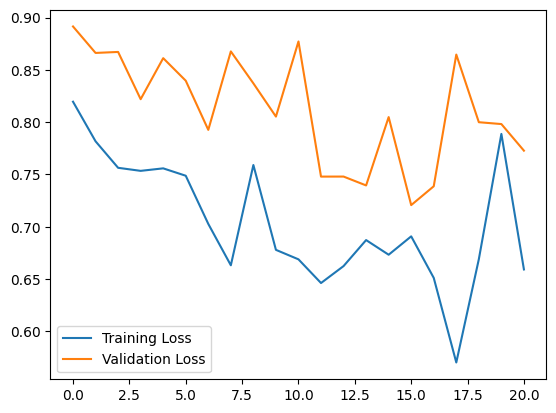

19/19 [==============================] - 1s 6ms/step
error_threshold 3.0989050895193433


In [24]:
val_err = model.train(x_train)


### Then we test

In [25]:
# predictions = []
# anomaly_scores = []

# for i in range(0,len(test_df),12*5):
#     if(i + 12*5 < len(test_df)):
#         sample_topredict_on = test_df.iloc[i:i+12*5]
# #         display(sample_topredict_on)
#         x_test = np.array(sample_topredict_on['node_cpu_utilization'].tolist())
#         x_test = x_test.reshape(1,-1,1)
#         preds,anom_scores = model.testnew(x_test)
#         predictions.append(preds)
#         anomaly_scores.append(anom_scores)




predictions = []
anomaly_scores = []
errors = []
for i in range(0,len(test_df),timesteps):
    if(i + timesteps < len(test_df)):
        sample_topredict_on = test_df.iloc[i:i+timesteps]
#         display(sample_topredict_on)
        x_test = np.array(sample_topredict_on['node_cpu_utilization'].tolist())
        x_test = x_test.reshape(1,-1,1)
        preds,errs,anom_scores = model.test(x_test)
        predictions.append(preds)
        errors.append(errs)
        anomaly_scores.append(anom_scores)



1/1 [==============================] - 0s 21ms/step


In [26]:
anomaly_scores = np.concatenate(np.concatenate(anomaly_scores,axis=0),axis=0)
errors = np.concatenate(np.concatenate(errors,axis=0),axis=0)
predictions = np.concatenate(np.concatenate(predictions,axis=0),axis=0)

df_results = test_df.iloc[0:len(anomaly_scores)]
df_results['predictions'] = predictions
df_results['error'] = errors
df_results['anom_score'] = anomaly_scores

def anom_threshold_function(x):
    if(x > 0.8): return True
    else: return False

df_results['is_anomaly'] = df_results['anom_score'].apply(anom_threshold_function)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

/root/eks-ml-pipeline/modeling/autoencoder_model_dish_5g.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[ANOMALIES_COLUMN] = results_df[ANOMALIES_COLUMN].fillna(False)


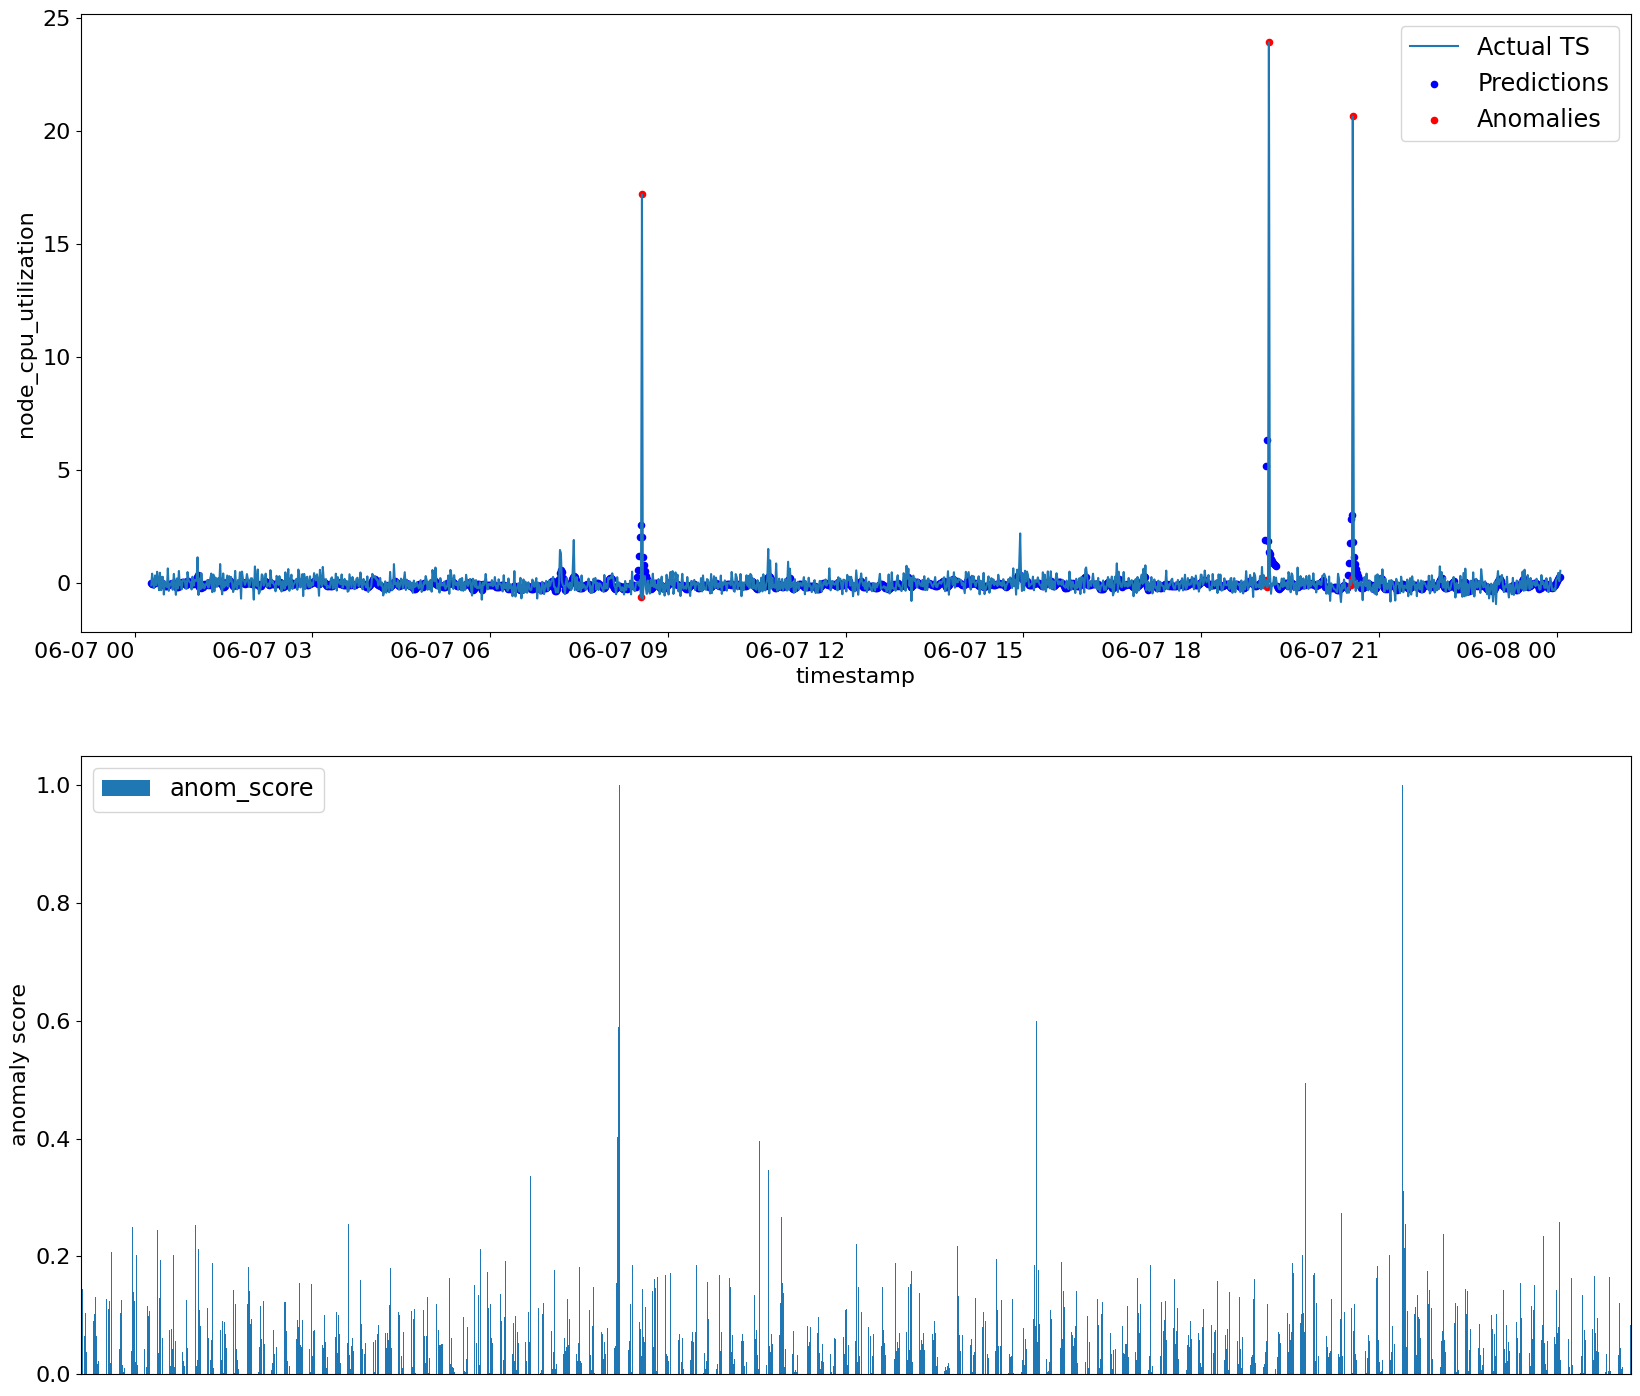

In [28]:
# evaluation_df[kad_utils.GROUND_TRUTH_COLUMN] = training_df_one_node[kad_utils.GROUND_TRUTH_COLUMN]
model.visualize(df_results, "node_cpu_utilization")
plt.show()